# I- Importation du fichier production

On commence par importer les bibliothèques

In [4]:
import pandas as pd
import numpy as np
import pickle # pour le chargement du modèle de régression logistique
import joblib # pour le chargement du modèle Random Forest
import tensorflow as tf # pour le chargement du modèle de réseau neuronal
import statsmodels.api as sm # pour l'ajout de la constante
import matplotlib.pyplot as plt

In [5]:
# Lecture du fichier avec , comme séparateur
data = pd.read_csv("data_raw/billets_production.csv", sep=',')

# Affiche les 5 premières lignes
data.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


On extrait 'id' pour ne garder que les colonnes numériques

In [6]:
# Extraire la colonne 'id' pour l'utiliser plus tard
data_ids = data['id']

In [7]:
# Exclure la colonne 'id' avant l'entraînement
X = data.drop(columns=['id'])
# Affiche les premières lignes sans la colonne 'id'
print(X.head())

   diagonal  height_left  height_right  margin_low  margin_up  length
0    171.76       104.01        103.54        5.21       3.30  111.42
1    171.87       104.17        104.13        6.00       3.31  112.09
2    172.00       104.58        104.29        4.99       3.39  111.57
3    172.49       104.55        104.34        4.44       3.03  113.20
4    171.65       103.63        103.56        3.77       3.16  113.33


# II- Chargement du modèle de régression logistique

In [8]:
# Charger le modèle sauvegardé
with open('logistic_model_aic.pkl', 'rb') as f:
    logistic_model_aic = pickle.load(f)

print("Modèle chargé avec succès.")


Modèle chargé avec succès.


On vérifie les colonnes utilisées dans le modèle

In [9]:
# Afficher les colonnes utilisées par le modèle AIC
print(logistic_model_aic.model.exog_names)


['const', 'height_right', 'margin_low', 'margin_up', 'length']


On exclue les colonnes qui ne sont pas présentes dans le modèle

In [10]:
# Exclure toutes les colonnes non pertinentes
X_aic = X[['height_right', 'margin_low', 'margin_up', 'length']]


On ajoute une colonne 'constante'

In [11]:
# Ajouter une colonne de constante (biais) à X
X_with_const = sm.add_constant(X_aic)

# Vérifier les premières lignes de X pour s'assurer que la constante est bien ajoutée
print(X_with_const.head())


   const  height_right  margin_low  margin_up  length
0    1.0        103.54        5.21       3.30  111.42
1    1.0        104.13        6.00       3.31  112.09
2    1.0        104.29        4.99       3.39  111.57
3    1.0        104.34        4.44       3.03  113.20
4    1.0        103.56        3.77       3.16  113.33


## Prédictions du modèle et probabilités

In [12]:
# Faire des prédictions avec le modèle chargé
reg_log_prob = logistic_model_aic.predict(X_with_const)
# Afficher les premières prédictions
print(reg_log_prob[:5])

0    0.000035
1    0.000002
2    0.000005
3    0.995109
4    0.999994
dtype: float64


In [13]:
# Appliquer un seuil pour obtenir les prédictions
threshold = 0.5
reg_log_pred = np.where(reg_log_prob > threshold, "True", "False")

# Afficher les premières prédictions
print(reg_log_pred[:5])


['False' 'False' 'False' 'True' 'True']


In [14]:
data["reg_log_pred"] = reg_log_pred
data["reg_log_prob"] = reg_log_prob * 100
data

,diagonal,height_left,height_right,margin_low,margin_up,length,id,reg_log_pred,reg_log_prob
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,0.003503
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,0.000171
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,0.000501
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,99.510899
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,99.999398


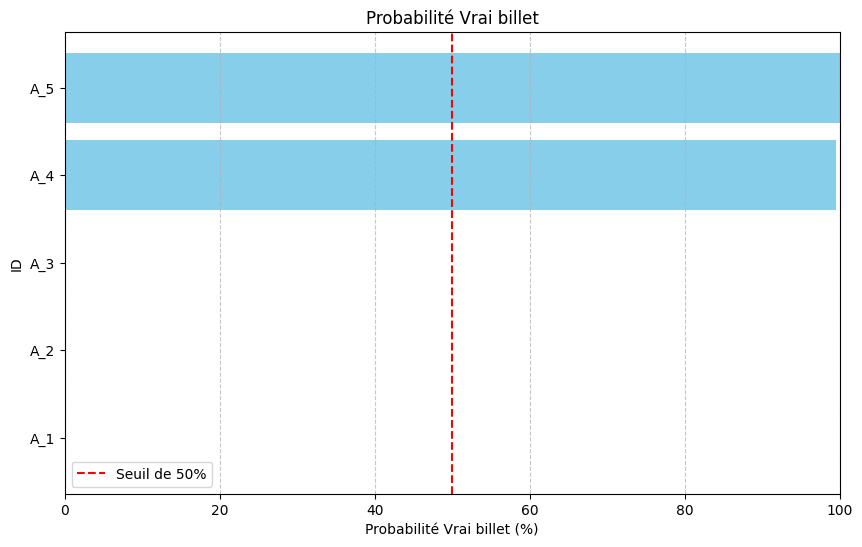

In [17]:
# Création d'un bar chart horizontal
plt.figure(figsize=(10, 6))
plt.barh(data['id'], data['reg_log_prob'], color='skyblue')
plt.xlabel('Probabilité Vrai billet (%)')
plt.ylabel('ID')
plt.title('Probabilité Vrai billet')
plt.xlim(0, 100)  # Limite de l'axe des x pour être entre 0 et 100
plt.axvline(x=50, color='red', linestyle='--', label='Seuil de 50%')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()